In [1]:
import pyproj
import itertools
import numpy as np
import verde as vd
import harmonica as hm
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

## Read magnetic anomaly data from Rio de Janeiro

In [2]:
# Fetch magnetic anomaly data from Rio de Janeiro
data = hm.datasets.fetch_rio_magnetic()

# Reduce region of the survey to speed things up
region = [-42.60, -42.40, -22.32, -22.20]
inside = vd.inside((data.longitude.values, data.latitude.values), region)
data = data[inside]

# Project coordinates
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data["easting"], data["northing"] = projection(
    data.longitude.values, data.latitude.values
)
coordinates = (data["easting"], data["northing"], data.altitude_m)

## Model selection

In [3]:
# Build combination of parameters
depths = [-100, -200, -300, -400, -500, -600, -700, -800, -900, -1000]
spacings = [375, 400, 500, 700, 900]

# Use itertools to create a list with all combinations of parameters to test
parameter_sets = [
    dict(extra_coords=combo[0], spacing=combo[1])
    for combo in itertools.product(depths, spacings)
]
print("Number of combinations:", len(parameter_sets))

Number of combinations: 50


In [4]:
region = vd.get_region(coordinates)
scores = []
gridder = hm.EQLHarmonic()

for params in parameter_sets:
    points = vd.grid_coordinates(region=region, **params)
    gridder.set_params(points=points)
    shuffle = ShuffleSplit(n_splits=10, test_size=0.3, random_state=1)
    score = np.mean(
        vd.cross_val_score(
            gridder, coordinates, data.total_field_anomaly_nt, cv=shuffle
        )
    )
    scores.append(score)
print("Scores: {}".format(scores))

Scores: [-556734664030.4724, -499120.74158331536, 0.44740034451345567, 0.9329197470840566, 0.9142265884815647, -155655047640.64908, -25102.14580129303, 0.8008154490045948, 0.9406668418351491, 0.9174787828157346, -28806680432.28512, -1729.7504450088145, 0.9372018637011923, 0.9454150292844732, 0.9180768858842633, -9697184364.266907, -578.2022338000136, 0.9720270538093428, 0.948164239768958, 0.9174681616575853, -147105722.2291295, -264.78348801708665, 0.9743131648665292, 0.9492844521334444, 0.9164391466408077, -18747805.240674436, -52.43462961431161, 0.9696718504926753, 0.9497806680426468, 0.9154230757432934, -20899150.77716489, -15.787774008578538, 0.9573179065976458, 0.9499402475227324, 0.9145908064645976, -2311287.616352499, -35.5158730409593, 0.9505826050586229, 0.9499358437076365, 0.9139131371735848, -4158408.2652493804, -19.937981585180818, 0.9548765174552699, 0.9498503687179103, 0.9133063929244782, -1747601.9700959078, -16.781256987676652, 0.9612591236916606, 0.9498662395604723, 0.

In [5]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Best parameters:", parameter_sets[best])

params = parameter_sets[best]
points = vd.grid_coordinates(region=region, **params)
gridder.set_params(points=points)
gridder.fit(coordinates, data.total_field_anomaly_nt)

Best score: 0.9743131648665292
Best parameters: {'extra_coords': -500, 'spacing': 500}


EQLHarmonic(damping=None, depth_factor=3, k_nearest=1,
            points=(array([[-4390840.57234644, -4390338.86136252, -4389837.15037861, ...,
        -4371273.84397379, -4370772.13298988, -4370270.42200596],
       [-4390840.57234644, -4390338.86136252, -4389837.15037861, ...,
        -4371273.84397379, -4370772.13298988, -4370270.42200596],
       [-4390840.57234644, -4390338.86136252, -4389837.15037861,...
       [-2332769.68173536, -2332769.68173536, -2332769.68173536, ...,
        -2332769.68173536, -2332769.68173536, -2332769.68173536]]),
                    array([[-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.],
       ...,
       [-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.]])))

## Predict values on a regular grid

In [6]:
# Interpolate data into the regular grid at 200m above the sea level
region = vd.get_region(coordinates)
grid = gridder.grid(
    region=region, spacing=250, data_names=["magnetic_anomaly"], extra_coords=200
)

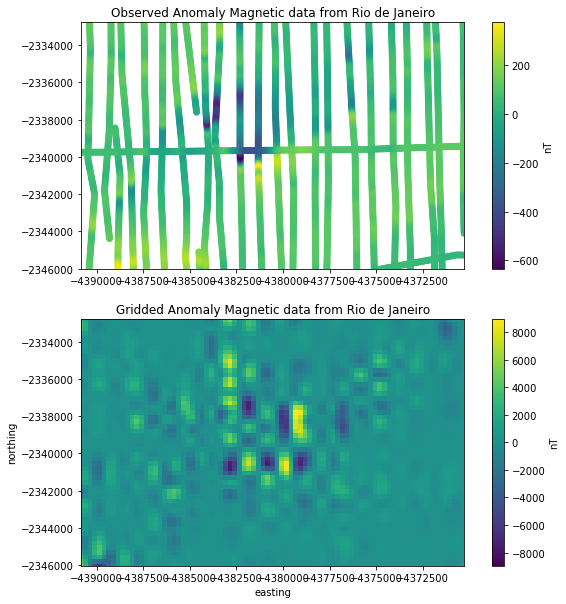

In [8]:
# Plot original magnetic anomaly
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
tmp = ax1.scatter(data.easting, data.northing, c=data.total_field_anomaly_nt)
plt.colorbar(tmp, ax=ax1, label="nT")
ax1.set_xlim(*region[:2])
ax1.set_ylim(*region[2:])
ax1.set_aspect("equal")
ax1.set_title("Observed Anomaly Magnetic data from Rio de Janeiro")

# Plot gridded magnetic anomaly
tmp = grid.magnetic_anomaly.plot.pcolormesh(ax=ax2, add_colorbar=False, cmap="viridis")
plt.colorbar(tmp, ax=ax2, label="nT")
ax2.set_xlim(*region[:2])
ax2.set_ylim(*region[2:])
ax2.set_aspect("equal")
ax2.set_title("Gridded Anomaly Magnetic data from Rio de Janeiro")
plt.show()